# Load Data

Create a dataframe with two columns: document labels and textual tokens:

In [6]:
#!python3 -m spacy download en
import pysolr
import requests
import json
import pandas as pd
import os
from datetime import datetime

# Set a local folder where models will be saved.
base_directory = os.getcwd()
print(base_directory)

# Setup a Solr instance. The timeout is optional.
solr = pysolr.Solr('http://librairy.linkeddata.es/data/covid-sentences')

# Set the query to filter the documents
solr_query="bionlp_atc5_t:[* TO *] AND scispacy_diseases_t:[* TO *]"

def get_key_tokens(document):
    keys = document["bionlp_atc5_t"].split(" ")
    tokens = ""
    for token in document['scispacy_diseases_t'].split(" "):
        if len(token)>2 and not token.isnumeric() and token.isalnum():
            tokens += token + " "
    return (keys,tokens)

# Create a dictionary with all the attribute values.
counter = 0
completed = False
window_size=1000
cursor = "*"
data={}
print("reading annotations...")
while (not completed):
    old_counter = counter
    try:
        documents = solr.search(q=solr_query,rows=window_size,cursorMark=cursor,sort="id asc")
        cursor = documents.nextCursorMark
        counter += len(documents)
        for document in documents:
            keys, tokens = get_key_tokens(document)
            for key in keys:
                if (not key in data):
                    data[key]=""
                data[key] += tokens
        if (old_counter == counter):
            print("done!")
            break
    except:
        print("Solr query error. Wait for 5secs..")
        time.sleep(5.0)
        
print(len(data.keys()),"drugs collected")               

/Users/cbadenes/Projects/librairy/public/covid19/atc-codes
reading documents...
done!
2687 drugs collected


# Vectorial Data Representation

## term frequency matrix

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vect = CountVectorizer()

X_freq = count_vect.fit_transform(list(data.values()))

df_freq = pd.DataFrame(X_freq.toarray(),columns=count_vect.get_feature_names(),index=data.keys())
df_freq

,1006magnification,17d,1959a,1986a,2000b,2010a,2011a,2016b,2078f,229e,...,zooepidemicus,zoster,zprmsole,zsofia,zst,zuccotti,zueva,zuniga,zygomycosis,zygraich
J07BB01,1,12,0,0,7,1,0,3,0,10,...,6,19,0,1,0,0,0,8,0,3
J07BH01,1,12,0,0,7,1,0,3,0,10,...,6,19,0,1,0,0,0,8,0,3
J07BG01,1,12,0,0,7,1,0,3,0,10,...,6,19,0,1,0,0,0,8,0,3
J07BC02,1,12,0,0,7,1,0,3,0,10,...,6,19,0,1,0,0,0,8,0,3
J07BH02,1,12,0,0,7,1,0,3,0,10,...,6,19,0,1,0,0,0,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01AB10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D10AB01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P02BX01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N05BE01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## tf/idf matrix

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.5, min_df=100)
X_tfidf=vectorizer.fit_transform(data.values())
df_tfidf = pd.DataFrame(X_tfidf.toarray(),columns=vectorizer.get_feature_names(),index=data.keys())
df_tfidf

,acidosis,aff,agarose,agitation,aids,aki,ali,allergic,allergy,als,...,ulceration,ulcers,uti,uveitis,vap,viremia,vomiting,vzv,wheezing,wilson
J07BB01,0.000154,0.000161,0.003820,0.000728,0.034798,0.000475,0.008758,0.001737,0.007007,0.000927,...,0.000484,0.001366,0.001874,0.002537,0.002565,0.066839,0.013209,0.053420,0.031048,0.006925
J07BH01,0.000154,0.000161,0.003671,0.000728,0.034833,0.000475,0.008767,0.001739,0.007014,0.000928,...,0.000485,0.001368,0.001876,0.002539,0.002568,0.066907,0.013341,0.053474,0.031079,0.006932
J07BG01,0.000154,0.000161,0.003822,0.000728,0.034821,0.000475,0.008764,0.001739,0.007012,0.000928,...,0.000485,0.001367,0.001876,0.002538,0.002567,0.066884,0.013218,0.053456,0.031068,0.006930
J07BC02,0.000152,0.000159,0.003921,0.000718,0.034682,0.000468,0.008645,0.001715,0.006916,0.001307,...,0.000478,0.001348,0.001850,0.002504,0.002690,0.066119,0.013038,0.053179,0.030796,0.006835
J07BH02,0.000154,0.000161,0.003671,0.000728,0.034833,0.000475,0.008767,0.001739,0.007014,0.000928,...,0.000485,0.001368,0.001876,0.002539,0.002568,0.066907,0.013341,0.053474,0.031079,0.006932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01AB10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D10AB01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P02BX01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N05BE01,0.000000,0.000000,0.000000,0.690375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Approximate Nearest Neighbour

# Dimensionality Reduction

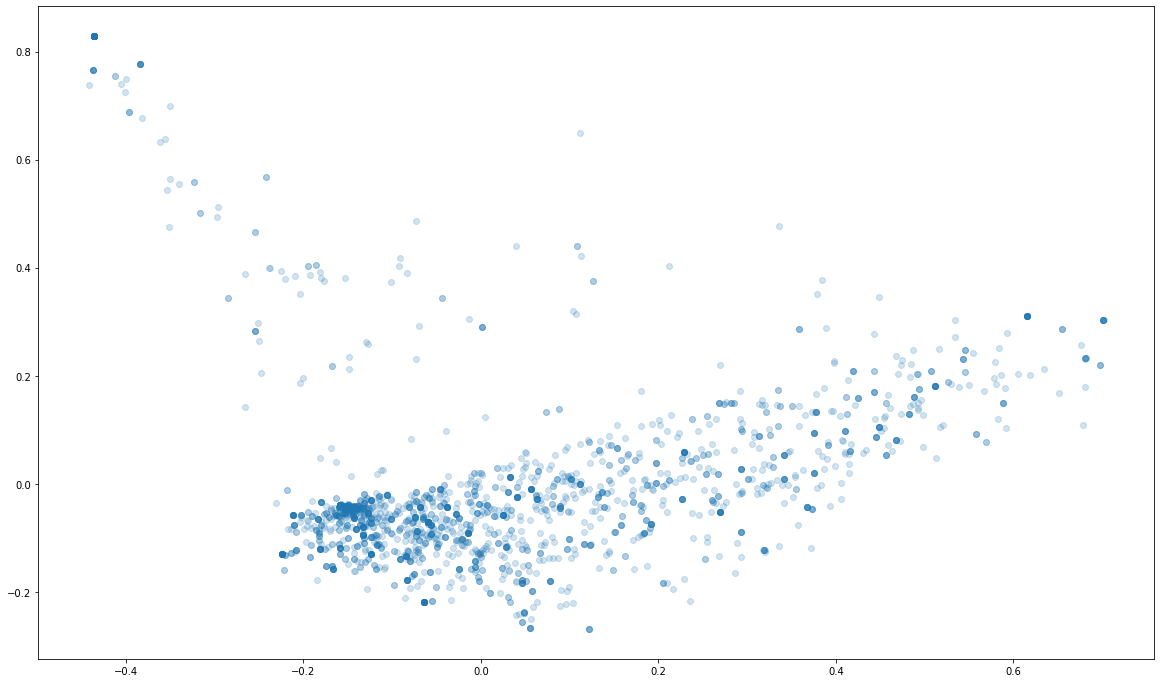

In [16]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(tfidf_vectors)

X = pca.transform(tfidf_vectors)


fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)

# Clustering

## Hierarchical Clustering

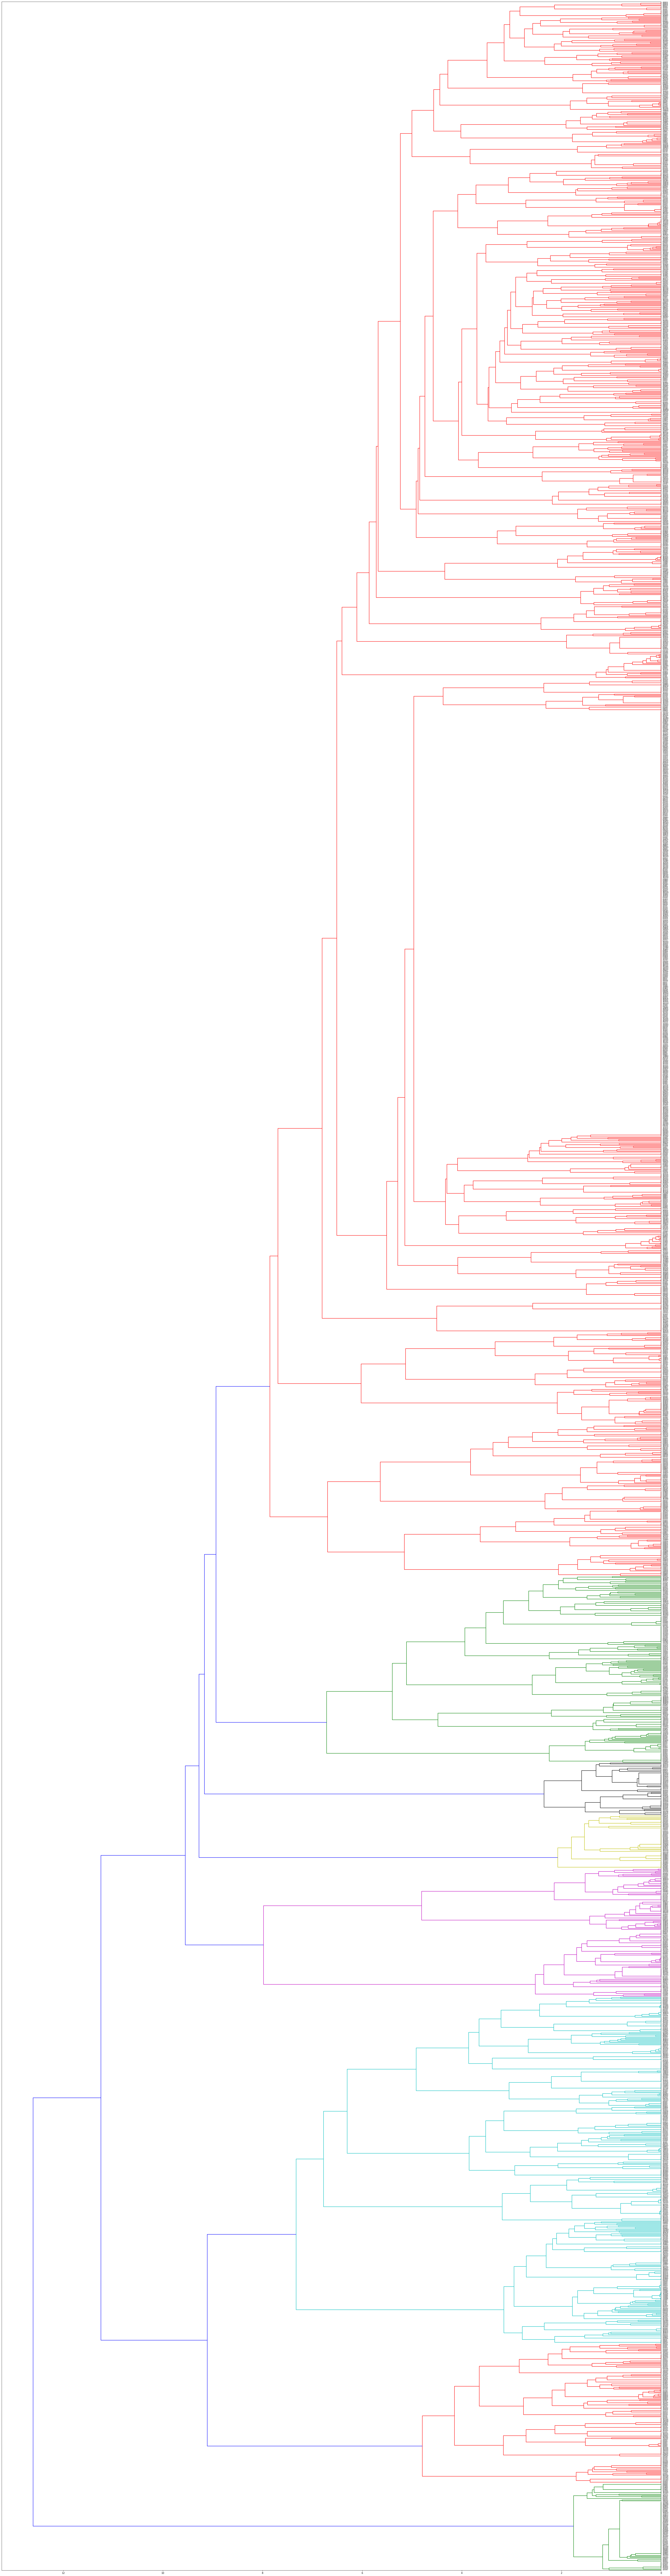

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

#  The distance function can be ‘braycurtis’, ‘canberra’, 
#‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
# ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
# ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

linked = linkage(tfidf_vectors, 'ward', 'euclidean')

labelList = list(drugs.keys())

plt.figure(figsize=(50, 200))  
dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

## Partitional Clustering

In [18]:
from sklearn.cluster import KMeans

num_clusters = 8

km = KMeans(n_clusters=num_clusters)

%time clusters=km.fit_predict(tfidf_vectors)
print(clusters)

CPU times: user 1.09 s, sys: 135 ms, total: 1.23 s
Wall time: 348 ms
[6 6 6 ... 0 0 0]


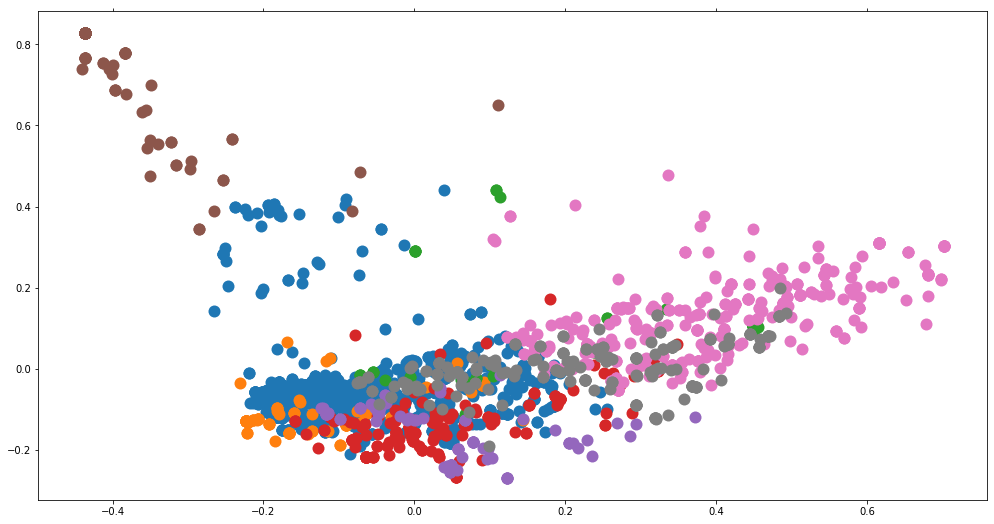

In [19]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

xs, ys = X[:, 0], X[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labelList)) 

#group by cluster
groups = df2.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    #ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
    #        label=cluster_names[name], color=cluster_colors[name], 
    #        mec='none')
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
             mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
#ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

For n_clusters = 4 The average silhouette_score is : 0.5449249371709959
For n_clusters = 6 The average silhouette_score is : 0.5056749059612266
For n_clusters = 8 The average silhouette_score is : 0.4840893379926627
For n_clusters = 10 The average silhouette_score is : 0.4882568622608599
For n_clusters = 12 The average silhouette_score is : 0.4927620993313332


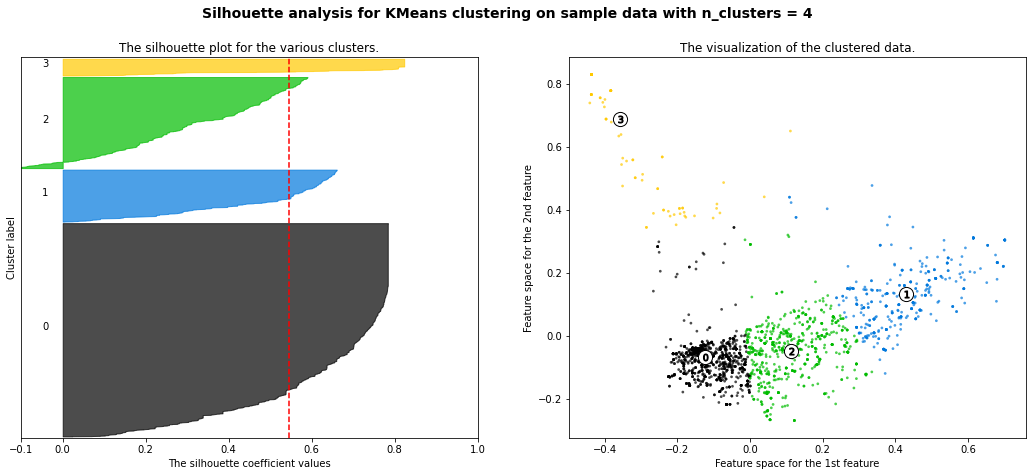

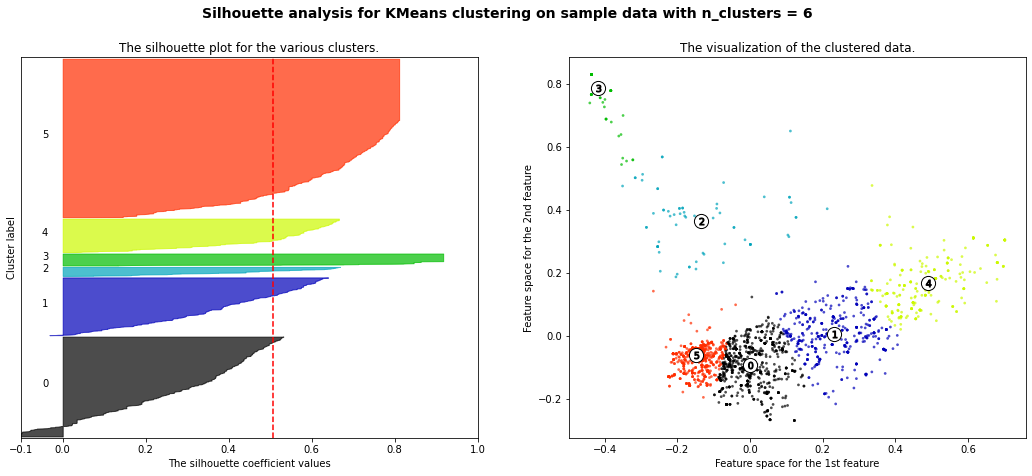

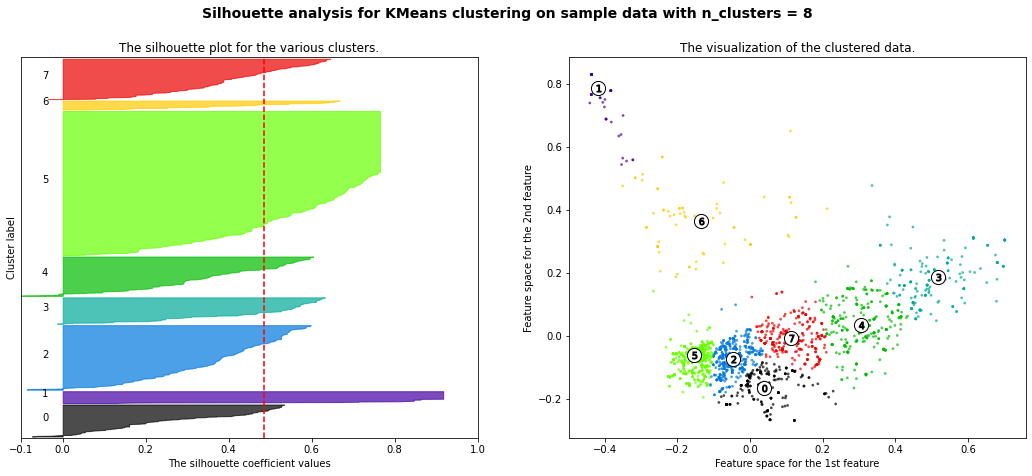

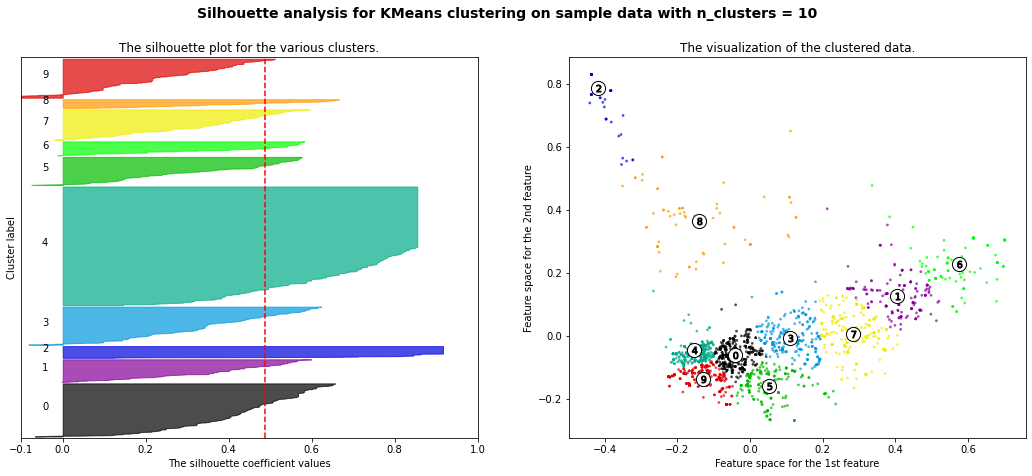

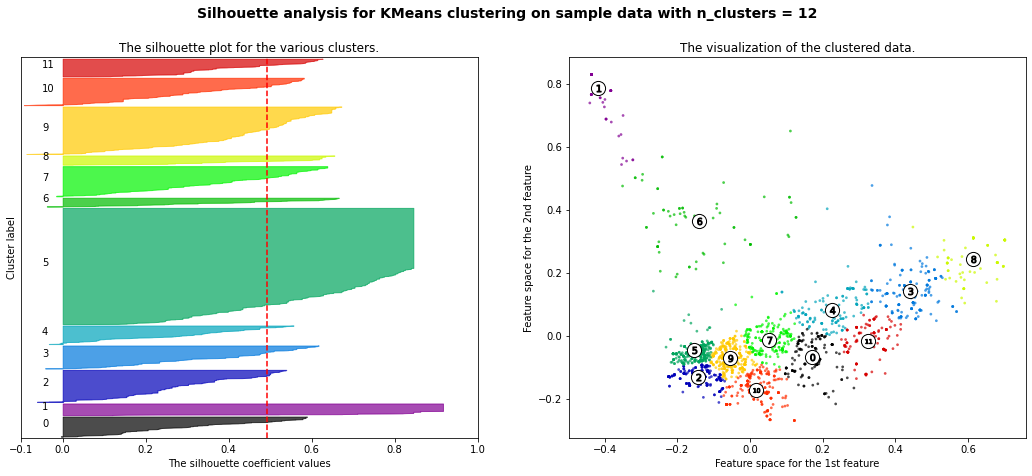

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [4, 6, 8, 10, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Density-based Clustering

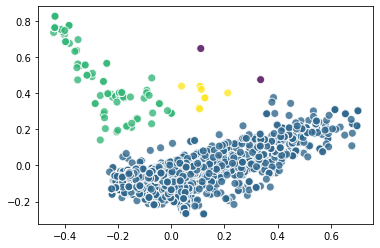

In [23]:
from sklearn.cluster import DBSCAN

dbs_1 = DBSCAN(eps=0.1, min_samples=3)
labels_1 = dbs_1.fit(X).labels_ 

plt.scatter(X[:,0], X[:,1], c=labels_1,
                   alpha=0.8, s=64, edgecolors='white')
plt.show()

# Exploration

## Clustering Browsing 

In [20]:
solr = pysolr.Solr('http://librairy.linkeddata.es/data/atc')

atc_code_sample = "J05AB01"
atc_code_name = ""
for result in solr.search("code_s:"+atc_code_sample):
    atc_code_name = result['label_t']

sample_idx = labelList.index(atc_code_sample)
sample_cluster = clusters[sample_idx]
print("Cluster #", sample_cluster)

i = 0;
founds = []
for cluster in clusters:
    if (cluster == sample_cluster):
        founds.append(labelList[i])
    i+=1
print(len(founds),"drugs found related to",atc_code_sample,":",atc_code_name)
max = 10
for found in founds:
    for atc_code in solr.search("code_s:"+found):
        print("->",atc_code['code_s'],":",atc_code['label_t'])

Cluster # 6
360 drugs found related to J05AB01 : aciclovir
-> J07BB01 : influenza, inactivated, whole virus
-> J07BH01 : rota virus, live attenuated
-> J07BG01 : rabies, inactivated, whole virus
-> J07BC02 : hepatitis a, inactivated, whole virus
-> J07BH02 : rota virus, pentavalent, live, reassorted
-> J07BA02 : encephalitis, japanese, inactivated, whole virus
-> J07BF03 : poliomyelitis, trivalent, inactivated, whole virus
-> J07BA01 : encephalitis, tick borne, inactivated, whole virus
-> B05BA01 : amino acids
-> N03AB03 : amino(diphenylhydantoin) valeric acid
-> B03AD01 : ferrous amino acid complex
-> J05AP01 : ribavirin
-> S01AD05 : interferon
-> L03AB03 : interferon gamma
-> L03AB09 : interferon alfacon-1
-> L03AB01 : interferon alfa natural
-> L03AB04 : interferon alfa-2a
-> L03AB08 : interferon beta-1b
-> L03AB06 : interferon alfa-n1
-> L03AB07 : interferon beta-1a
-> L03AB05 : interferon alfa-2b
-> L03AB02 : interferon beta natural
-> J05AB13 : penciclovir
-> D06BB06 : penciclovi

-> S01AD03 : aciclovir
-> D06BB03 : aciclovir
-> J05AB01 : aciclovir
-> D06BB53 : aciclovir, combinations
-> J02AC03 : voriconazole
-> A10AF01 : insulin (human)
-> A10AE01 : insulin (human)
-> A10AD01 : insulin (human)
-> A10AB01 : insulin (human)
-> A10AC01 : insulin (human)
-> B02BB01 : fibrinogen, human
-> G03GA02 : human menopausal gonadotrophin
-> S01AX09 : chlorhexidine
-> S03AA04 : chlorhexidine
-> S02AA09 : chlorhexidine
-> D09AA12 : chlorhexidine
-> R02AA05 : chlorhexidine
-> B05CA02 : chlorhexidine
-> D08AC02 : chlorhexidine
-> A01AB03 : chlorhexidine
-> D08AC52 : chlorhexidine, combinations
-> A16AX13 : uridine triacetate
-> B03AB08 : ferric acetyl transferrin
-> A11HA05 : biotin
-> R07AA01 : colfosceril palmitate
-> V09IA02 : technetium (99mtc) antimelanoma antibody
-> V09IA01 : technetium (99mtc) anticarcinoembryonicantigen antibody
-> V09IB03 : indium (111in) antiovariumcarcinoma antibody
-> V09HA03 : technetium (99mtc) antigranulocyte antibody
-> V09IX03 : iodine (125i) 

##  Approximate Nearest Neighbour

In [14]:
from annoy import AnnoyIndex
import random

labels = list(data.keys())
tfidf_vectors = df_tfidf.to_numpy().tolist()

f = len(tfidf_vectors[0])
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
i=0
print("adding vector..")
annoy_dict={}
for vector in tfidf_vectors:
    t.add_item(i, vector)
    annoy_dict[labels[i]]=i
    i+=1
print("all vector added")
t.build(10) # 10 trees
t.save(base_directory+'/index.annoy')
print("annoy index created successfully")






adding vector..
all vector added
annoy index created successfully


In [15]:
#u = AnnoyIndex(f, 'angular')
#u.load('test.ann') # super fast, will just mmap the file
#search_word ="J01FA10"
search_word="L01XX57"
# https://www.sefh.es/fichadjuntos/RESUMENINTERACCIONESCOVID19asma.pdf
ref_index = annoy_dict[search_word]
print("getting neighbour of ",labels[ref_index])
atc_solr = pysolr.Solr('http://librairy.linkeddata.es/data/atc')

for neighbour in t.get_nns_by_item(ref_index, 10):
    atc_results = atc_solr.search("code_s:"+labels[neighbour])
    for atc_result in atc_results:
        print(labels[neighbour],":",atc_result['label_t'])



getting neighbour of  L01XX57
L01XX57 : plitidepsin
L01XE09 : temsirolimus
L01DB11 : pixantrone
L02BG04 : letrozole
L04AA40 : cladribine
L01BB04 : cladribine
V04CH02 : indigo carmine
V09HA04 : technetium (99mtc) sulesomab
A10AE04 : insulin glargine
A10AE54 : insulin glargine and lixisenatide


## Statistics

In [25]:
data_stats = {}
data_stats['annotation']=["bionlp_atc2_t","bionlp_atc3_t","bionlp_atc4_t","bionlp_atc5_t","pubchem_cids_t","scispacy_chemicals_t","scispacy_diseases_t","snomed_diseases_concept_id"]
#data_stats['frequency']=[303,11185,119796,315436,294582,103508,723575,759375]
data_stats['frequency']=[5,52,135,126,44,310,326,25]

df_stats = pd.DataFrame (data_stats, columns = ['annotation','frequency'])

df_stats.to_csv(base_directory+'/annotations.csv', index = False)
df_stats.head()

,annotation,frequency
0,bionlp_atc2_t,5
1,bionlp_atc3_t,52
2,bionlp_atc4_t,135
3,bionlp_atc5_t,126
4,pubchem_cids_t,44


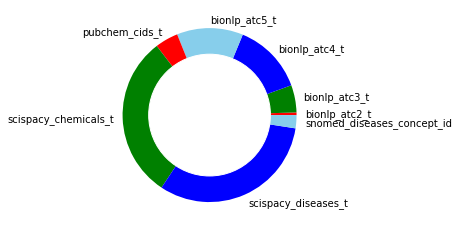

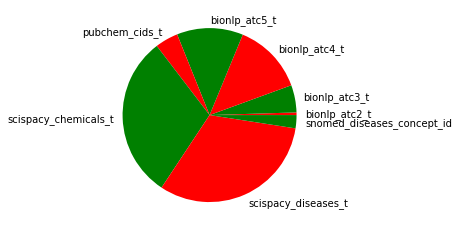

In [28]:
# library
import matplotlib.pyplot as plt
 
# create data
names=data_stats['annotation']
size=data_stats['frequency']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
# Give color names
plt.pie(size, labels=names, colors=['red','green','blue','skyblue'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
 
# Custom colors --> colors will cycle
plt.pie(size, labels=names, colors=['red','green'])
p=plt.gcf()
plt.show()
